# Topographic analysis code
A results notebook for analysing synthetic landscapes
* Steady-state landscape
* Faulted landscape

In [1]:
from landlab import RasterModelGrid, imshow_grid
from landlab.components import FlowAccumulator, ChannelProfiler, ChiFinder, SteepnessFinder
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from FieldWork_class import FieldWork
import pandas as pd
from time import time

In [2]:
def plot_topographic_metrics(grid_, channel_profiler_, time_, save=False):
    """ Produce a four-panel plot of topographic metrics for a landscape.
    (a) Elevation map
    (b) Longitudinal profiles
    (c) Chi map
    (d) Chi profiles
    (e) Channel steepness map

    Parameters:
    -----------------
    grid_: Landlab RasterModelGrid
    channel_profiler_: Landlab ChannelProfiler object
    time_: Age of the landscape in kyr
    save: Save the resulting figure as png in the current directory. Default is false

    Returns figure.
    """
    
    # Instantiate figure
    fig = plt.figure(figsize=(10, 10))
    shp = (3, 2)
    ax0 = plt.subplot2grid(shp, (0, 0), rowspan=1, colspan=1, aspect='auto')  # Topo with rivers
    ax1 = plt.subplot2grid(shp, (0, 1), rowspan=1, colspan=1, aspect='auto')  # Long profiles
    ax2 = plt.subplot2grid(shp, (1, 0), rowspan=1, colspan=1, aspect='auto')  # Chi map
    ax3 = plt.subplot2grid(shp, (1, 1), rowspan=1, colspan=1, aspect='auto')  # chi values
    ax4 = plt.subplot2grid(shp, (2, 0), rowspan=1, colspan=1, aspect='auto')  # steepness map

    # Colorbar axes
    divider0 = make_axes_locatable(ax0)
    cbar_ax0 = divider0.append_axes("left", size="5%", pad=0.5)
    divider2 = make_axes_locatable(ax2)
    cbar_ax2 = divider2.append_axes("left", size="5%", pad=0.5)
    divider4 = make_axes_locatable(ax4)
    cbar_ax4 = divider4.append_axes("left", size="5%", pad=0.5)
    cbar_ax4.yaxis.set_ticks_position('left')
    
    # # Axes ticks and labels
    # xticks = np.array([0, 2000, 4000, 6000, 8000, 10000, 12000, 14000])
    # xlabels = [0, 2, 4, 6, 8, 10, 12, 14]
    # yticks = np.array([0, 2000, 4000, 6000, 8000, 10000])
    # ylabels = [0, 2, 4, 6, 8, 10]

    # Extract max dimensions from grid
    max_x = grid_.x_of_node[-1]
    max_y = grid_.y_of_node[-1]
    
    # Plot topography with long profiles
    im0 = ax0.imshow(grid_.at_node['topographic__elevation'].reshape(grid_.shape), aspect='auto', origin='lower',
                     cmap='terrain', extent=[0, max_x, 0, max_y])
    ax0.set_xlabel('Distance [m]'), ax0.set_ylabel('Distance [m]')
    # ax0.set_xticks(xticks, xlabels)
    # ax0.set_yticks(yticks, ylabels)
    ax0.yaxis.set_label_position("right")
    ax0.yaxis.tick_right()
    # Line segments for Long Profiles
    endpoints_only = False
    segments = []
    for nodes in channel_profiler_.nodes:
        if endpoints_only:
            select_nodes = [nodes[0], nodes[-1]]
            segments.append(list(zip(
                        grid_.x_of_node[select_nodes],
                        grid_.y_of_node[select_nodes])))
        else:
            segments.append(list(zip(grid_.x_of_node[nodes], grid_.y_of_node[nodes])))
    
    line_segments = LineCollection(segments)
    colors = channel_profiler_.colors
    line_segments.set_color(colors)
    ax0.add_collection(line_segments)
    # Add text
    ax0.text(0.5, 0.98, f'$\\tau$ = {time_} kyr', transform=ax0.transAxes, ha='center', va='top', bbox=dict(fc='w'))
    ax0.text(0.015, 0.98, 'a', transform=ax0.transAxes, ha='left', va='top', bbox=dict(fc='w'))
    cb0 = plt.colorbar(im0, cax=cbar_ax0, orientation='vertical', label='Elevation [m]')
    cb0.ax.yaxis.set_ticks_position('left'), cb0.ax.yaxis.set_label_position('left')
    
    # Plot long profiles
    plt.subplot(322)
    channel_profiler_.plot_profiles(xlabel='Upstream Distance [m]',
                      ylabel='Elevation [m]', title='Longitudinal Profiles')
    ax1.text(0.015, 0.98, 'b', transform=ax1.transAxes, ha='left', va='top', bbox=dict(fc='w'))
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()

    # Plot chi map
    im2 = ax2.imshow(grid_.at_node['channel__chi_index'].reshape(grid_.shape), aspect='auto', origin='lower',
                     cmap='jet', extent=[0, max_x, 0, max_y])
    ax2.set_xlabel('Distance [m]'), ax2.set_ylabel('Distance [m]')
    # ax2.set_xticks(xticks, xlabels)
    # ax2.set_yticks(yticks, ylabels)
    ax2.text(0.015, 0.98, 'c', transform=ax2.transAxes, ha='left', va='top', bbox=dict(fc='w'))
    cb2 = plt.colorbar(im2, cax=cbar_ax2, label='Chi index [m]', orientation='vertical')
    cb2.ax.yaxis.set_ticks_position('left'), cb2.ax.yaxis.set_label_position('left')
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    
    # Plot chi profiles
    plt.subplot(324)
    for i, outlet_id in enumerate(channel_profiler_.data_structure):
        for j, segment_id in enumerate(channel_profiler_.data_structure[outlet_id]):
            if j == 0:
                label = f"channel {i + 1}"
            else:
                label = "_nolegend_"
            segment = channel_profiler_.data_structure[outlet_id][segment_id]
            profile_ids = segment["ids"]
            color = segment["color"]
            plt.plot(
                grid_.at_node["channel__chi_index"][profile_ids],
                grid_.at_node["topographic__elevation"][profile_ids],
                color=color,
                label=label,
            )
    
    ax3.set_xlabel("Chi Index [m]")
    ax3.set_ylabel("Elevation [m]")
    ax3.text(0.015, 0.98, 'd', transform=ax3.transAxes, ha='left', va='top', bbox=dict(fc='w'))
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()

    # Plot channel steepness
    im4 = ax4.imshow(grid_.at_node['channel__steepness_index'].reshape(grid_.shape), origin='lower', aspect='auto',
                    cmap='jet', extent=[0, max_x, 0, max_y])
    ax4.set_xlabel('Distance [m]'), ax4.set_ylabel('Distance [m]')
    # ax4.set_xticks(xticks, xlabels)
    # ax4.set_yticks(yticks, ylabels)
    ax4.text(0.015, 0.98, 'e', transform=ax4.transAxes, ha='left', va='top', bbox=dict(fc='w'))
    cb4 = plt.colorbar(im4, cax=cbar_ax4, label='Steepness index', orientation='vertical')
    cb4.ax.yaxis.set_ticks_position('left'), cb4.ax.yaxis.set_label_position('left')
    ax4.yaxis.set_label_position("right")
    ax4.yaxis.tick_right()
    
    plt.tight_layout()

    if save:
        plt.savefig('synthetic_results_' + time_ +'.png', dpi=300)

    return None

## Load landscapes
* Load as .npy file
* Instantiate onto a grid
* Recalculate drainage area
* Run Channel Profiler, ChiFinder, SteepnessFinder
* Run plot function

In [3]:
# Load landscapes
final_ss = np.load('elevation_timestep_42100.npy')
print(final_ss.shape)

(37296,)


In [4]:
# Reinstatiate the grid, with the correct dimensions
#Import you field work data
data = pd.read_csv('field_work_teton_park.csv')
x_size = 20000  # m
y_size = 11250  # m
dx = 60  # 
dy = 100  # m

#Calculate parameters for your model
fw = FieldWork(data)
rows, cols = map(int, fw.calculate_grid_size(x_size, y_size, dx, dy))
print(rows, cols)

Your area has 20000 km x 11250 km, the grid has 112.5 rows and 333.3333333333333 columns
112 333


In [5]:
# Instantiate onto a Landlab grid
grid = RasterModelGrid((rows, cols), xy_spacing=(dx, dy))
print(grid.shape)

(112, 333)


In [6]:
# Add as a grid field
elev = grid.add_zeros('topographic__elevation', at='node', clobber=True)
elev += final_ss

# Run flow accumulation to calculate drainage area
fa = FlowAccumulator(grid, flow_director='D8')
fa.run_one_step()

In [7]:
# Extract rivers
cp = ChannelProfiler(grid, number_of_watersheds=5)
cp.run_one_step()

# Extract chi
cf = ChiFinder(grid, min_drainage_area=1000.0, reference_concavity=0.45, clobber=True)
cf.calculate_chi()

# Calculate channel steepness
sf = SteepnessFinder(grid, reference_concavity=0.45, min_drainage_area=1000.0)
sf.calculate_steepnesses()

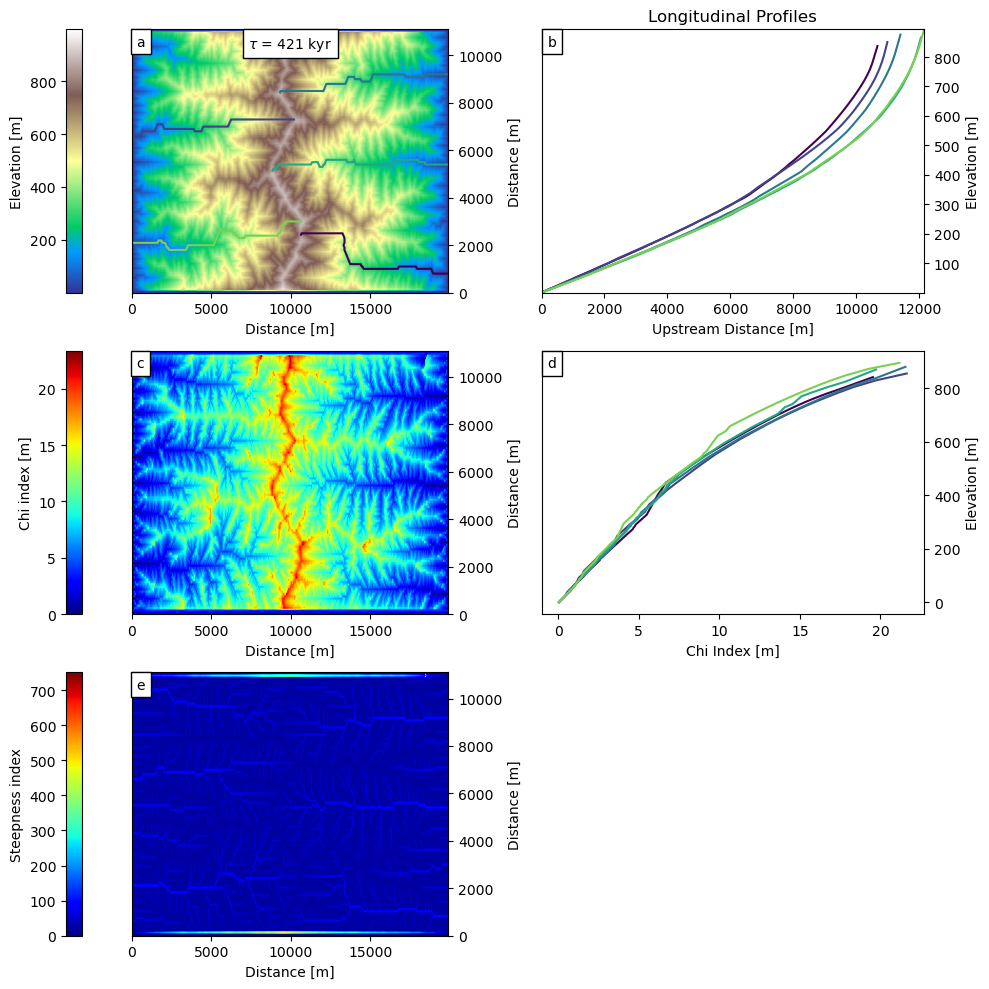

In [9]:
# Plot results
age = 421  # kyr
plot_topographic_metrics(grid, cp, age, save=False)